# Dynamically Dimensioned Search (DDS)
DDS is a optimization algorithm developed by [Tolson & Shoemaker (2007)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005WR004723) which focuses on finding the global optimum in a pre-specified number of function evaluations. This makes it especially useful for problems where the function evauation itself can be expensive. It can be adapted to both continuous and integer variables. DDS is especially good for high dimensional problems $(>\sim 6)$.

## General Description
The DDS algorithm has the following steps:

1. Pick $x_{best} = $ initial guess of the solution.
2. Randomly determine which of the decision variables to perturb.
3. Compute $x_{new}$ by adding to $x_{best}$ a pertubation taken from $\mathcal{N} (0, \sigma)$ for the components that were selected in step 2.
4. If $Cost(x_{new}) < Cost(x_{best})$, then $x_{best} = x_{new}$. Else do nothing.
5. If maximum number of function evaluations achieved, then stop. Otherwise goto step 2.

Since the problem can have $D$ number of dimensions, the possible combinations of pertubation is $2^D$. The method is called "dynamically dimensioned" as the number of dimensions perturbed is changed from iteration to iteration. The length of the pertubation is a (reflected) random variable $\mathcal{N} (0, \sigma)$, and hence can be either positive or negative.

The maximum number of function evaluations allowed, $m$, also changes the algorithm. The main idea is that we want to gradually decrease the numebr of dimensions perturbed as the number of iterations increases. This rate of decrease in the number of dimensions depends on $m$. DDS gradually decreases the probability that any one element is selected for pertubation using the formula:

$$P(i) = 1-\frac{ln(i)}{ln(m)}$$

where $P(i)$ is the probability of pertubation in the $i$th iteration. Other forms of $P(i)$ can be used, but htey must be monotonically decreasing. If no dimension is selected for pertubation in an iteration, then 1 dimension is selected at random to generate $x_{new}$.

## Implementation Details
0. **DDS Inputs:**
  * neighborhood pertubation size parameter, $r$ (0.2 is deafult)
  * maximum number of function evaluations, $m$
  * lower, $x^{min}$, and upper, $x^{max}$, bounds for all $d$ decision variables
  * initial solution, $x^0 = [x_1, \ldots, x_d]$
1. Set counter $i=1$, and evaluate function $F$ at initial solution $\to F^{best} = F(x^0), x^{best} = x^0$.
2. Using probability $P(i) = 1-\frac{ln(i)}{ln(m)}$ select $J$ of the $D$ decision variables for inclusion in set of perturbed varaibles, $\{R\}$ in iteration $i$. Add the pertubations to $\{R\}$. If $\{R\} = \phi$ then seect one random dimension.
3. For $j\in (1,\ldots, J)$ decision variables in $\{R\}$, perturb $x^{best}_j$ using a standard normal random variable, \mathcal{N} (0, 1), reflecting the decision variable bounds if necessary.
$$x_j^{new} = x_j^{best} + \sigma_j \mathcal{N}(0,1),\quad\text{where }\sigma_j = r(x_j^{max} - x_j^{min})$$
  * **Reflection** has the property of reflecting the part of the probability distribution outside the maimum and minimum bounds back into bounds (similar to what is shown in the figure below). This refers to the folllowing operation:
    * If $x_j^{new} < x_j^{min}\to x_j^{new} = x_j^{min} + (x_j^{min} - x_j^{new})$. If this leads to $x_j^{new} > x_j^{max}\to x_j^{new} = x_j^{min}$
    * If $x_j^{new} > x_j^{max}\to x_j^{new} = x_j^{max} - (x_j^{new} - x_j^{max})$. If this leads to $x_j^{new} < x_j^{min}\to x_j^{new} = x_j^{max}$
    
    ![Reflected Gaussian](Images/reflected_gaussian.png)
4. Evaluate $F(x^{new})$ and update the current best solution if necessary: If $F(x^{new})\leq F^{best}\to F^{best} = F(x^{new}), x^{best}=x^{new}$
5. Udate iteration count $i = i+1$ and check stopping criteron: If $i=m$, then return $F^{best}, x^{best}$. Else, goto 2.

Since $r$ can be set to $0.2$, and $m$ is a non-calibrated parameter, DDS essentially has no parameters to be calibrated.

## DDS vs. Other Algorithms
* **DDS vs. Simulated Annealing:**
  * Similarities: Big changes in current solution are less likely to occur as the number of iterations increase. SA stops uphill move in later iteartions, whereas DDS stops changes in many dimensions. You can use the maximum number of allowed evaluations to change this for both SA and DDS.
  * Difference: Maximum number of evaluations is incorporated directly into DDS. However, DDS does not accept uphill moves, whereas SA does. DDS is also usually more effective in high dimensional problems.
* **DDS vs. Greedy Search:**
  * Similarities: Both accept a new move only if they are downhill.
  * Difference: Probability of moving from one state to another is constant in greedy search, but changes for DDS.
* **DDS vs. Genetic Algorithms:**
  * Similarities: GA mutation is similar to choice of dimensions to perturn in DDS

DDS is not particularly good compared ot other algorithms when the dimensionality of the problem is low. This is because of the curse of dimensionality. As the dimensions of the problem grow, the solution space grows exponentially. This makes it difficult for other algorithms to search the space. With DDS, by reducing the number of perturbed dimensions you reduce the size of the neighborhood and reduce the chance of destroying the current best solution by changing it too much.

## Optimizing the "bump" function using DDS
The bump function to be optimized (maximized) is defined below:

$f(\overrightarrow{x})=
\begin{cases}
|\frac{\sum_{i=1}^n cos^4(x_i) - 2\prod_{i=1}^n cos^2(x_i)}{\sqrt{\sum_{i=1}^n ix_i^2}}|,\quad\text{if } (\forall i, 0\leq x_i \leq 10)\text{ and }(\prod_{i=1}^n x_i \geq 0.75)\\
0,\quad\text{otherwise}
\end{cases}$

In [1]:
import numpy as np
from math import log
from matplotlib import pyplot as plt

In [2]:
def bump(x):
    '''
    Evaluate the bump function for value x
    :param x: (d,) numpy array of the value
    '''
    d = x.shape[0]
    if any(x<0) or any(x>10) or np.product(x) < 0.75:
        return 0
    sum1 = np.sum(np.cos(x)**4)
    tim1 = 2 * np.product(np.cos(x)**2)
    sum2 = np.sqrt(np.sum(np.arange(1,d+1)*x**2))
    return abs((sum1 - tim1)/sum2)

In [3]:
class DDS():
    def __init__(self, function, x_min, x_max, max_evals, r=0.2, x_initial=None):
        '''
        Run DDS optimization (maximization) for given function
        :param function: function to optimize which accepts (d,) numpy input
        :param x_min: (d,) numpy array of minimum values for each dimension
        :param x_max: (d,) numpy array of maximum values for each dimension
        :param max_evals: maximum number of allowed function evaluations
        :param r: parameter to scale pertubations. Default: 0.2
        :param x_initial: Initial vairable. Default: None (choose randomly between [x_min, x_max))
        '''
        self.d = len(x_min)
        self.x_min = x_min
        self.x_max = x_max
        self.f = function
        self.r = r
        self.m = max_evals
        self.best = x_initial if x_initial is not None else np.random.rand(self.d)*(x_max-x_min)+x_min
        self.best_cost = self.f(self.best)

    def run(self):
        x_range = self.x_max - self.x_min
        best_costs = []
        for i in range(1, self.m+1):
            dim_perturb = (np.random.rand(self.d) < 1-(log(i)/log(self.m))).astype('float')
            k = np.count_nonzero(dim_perturb)
            if k == 0:
                dim_perturb[np.random.randint(0, high=self.d, size=1)[0]] = 1.0
                k = 1
            dim_perturb[dim_perturb!=0] = np.random.normal(size=k)
            curr = self.best + dim_perturb*self.r*x_range

            reflect_min = curr < self.x_min
            curr[reflect_min] = 2*self.x_min[reflect_min] - curr[reflect_min]
            correct_twice = np.logical_and(reflect_min, curr>self.x_max)
            curr[correct_twice] = self.x_min[correct_twice]

            reflect_max = curr > self.x_max
            curr[reflect_max] = 2*self.x_max[reflect_max] - curr[reflect_max]
            correct_twice = np.logical_and(reflect_max, curr<self.x_min)
            curr[correct_twice] = self.x_max[correct_twice]

            curr_cost = self.f(curr)
            if curr_cost > self.best_cost:
                self.best = curr
                self.best_cost = curr_cost
            
            best_costs.append(self.best_cost)

        return best_costs

    def plot(self):
        best_costs = self.run()
        plt.plot(np.arange(len(best_costs)), best_costs)
        plt.xlabel('Iteration number')
        plt.ylabel('Optimal function value')
        plt.title('Optimal function value vs. iterations')

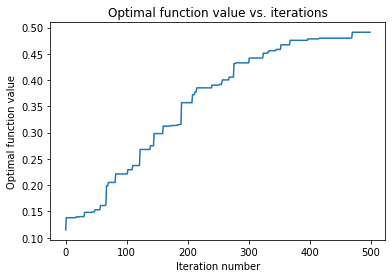

In [4]:
d = 20
dds = DDS(bump, x_min=np.zeros(d), x_max=10*np.ones(d), max_evals=500)
dds.plot()

In [5]:
n_trials = 20
max_iter = 500
costs = np.empty((n_trials, max_iter))
for i in range(n_trials):
    dds = DDS(bump, x_min=np.zeros(d), x_max=10*np.ones(d), max_evals=max_iter)
    costs[i] = dds.run()

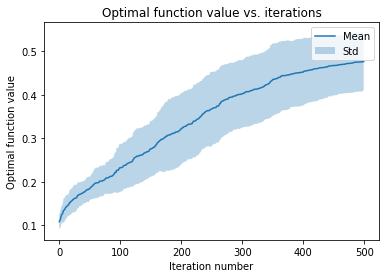

In [6]:
mean = np.average(costs, axis=0)
std = np.std(costs, axis=0)
plt.plot(np.arange(max_iter), mean)
plt.fill_between(np.arange(max_iter), mean-std, mean+std, alpha=0.3)
plt.xlabel('Iteration number')
plt.ylabel('Optimal function value')
plt.title('Optimal function value vs. iterations')
plt.legend(['Mean', 'Std'])